In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from arion.models.core import  ArionModel

In [2]:
df_race = pd.read_csv("../data/results/processed/results_processed.csv", parse_dates=['date','datetime'])
df_race = df_race.drop_duplicates(subset=['date','horse_name'])

In [17]:
train = df_race.loc[(df_race.date < '2020-01-01')].copy()
test = df_race.loc[(df_race.date >= '2020-01-01') & (df_race.date < '2022-04-01')].copy()
not_features = ['race_id','date','datetime','won','price','horse_name','finish_pos'] + [i for i in df_race.columns if "_age" in i]

In [18]:
model = ArionModel(not_features=not_features)
model.train(train=train)

[LightGBM] [Info] Total Bins 41975
[LightGBM] [Info] Number of data points in the train set: 648353, number of used features: 178
[LightGBM] [Info] Total Bins 41963
[LightGBM] [Info] Number of data points in the train set: 486264, number of used features: 178
[LightGBM] [Info] Total Bins 41962
[LightGBM] [Info] Number of data points in the train set: 486265, number of used features: 178
[LightGBM] [Info] Total Bins 41968
[LightGBM] [Info] Number of data points in the train set: 486265, number of used features: 178
[LightGBM] [Info] Total Bins 41929
[LightGBM] [Info] Number of data points in the train set: 486265, number of used features: 178
[LightGBM] [Info] Number of positive: 69665, number of negative: 578688
[LightGBM] [Info] Total Bins 42485
[LightGBM] [Info] Number of data points in the train set: 648353, number of used features: 180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [11]:
feature_imp = (
    pd.DataFrame({
        'feature': model.lgbst_rank.feature_name(),
        'importance': model.lgbst_rank.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

In [19]:
def bet_simulate(t, kelly_min, prob_min ,starting_balance):
    trial = df_race.loc[t.index,["race_id","last_price","won","date","price","horse_name"]].copy()

    trial["pred_prob"] = model.predict(X=t)
    trial["pred_sp"] = 1/trial["pred_prob"]
    trial["kelly"] = ((trial["pred_prob"]*trial["last_price"]) - 1)/(trial["last_price"] - 1)

    trial["bet"] = (trial["pred_prob"] > prob_min)  & (trial['kelly'] > kelly_min) & (trial['kelly'] == trial.groupby('race_id')['kelly'].transform('max'))
    isnoise = [len(str(i)) > 5 for i in trial["last_price"]]
    trial.loc[isnoise,"last_price"] = trial.loc[isnoise,"price"]
    trial["winnings"] = (trial['bet'] * trial["kelly"] * starting_balance * trial["last_price"] * trial["won"] * 0.95) - (trial['bet'] * trial["kelly"] * starting_balance)
    trial["bank"] = trial["winnings"].cumsum()
    trial["bet size"] = trial["bet"]*trial["kelly"]*starting_balance

    return trial

def evaluate(t,prob_min = 0.2,kelly_min = 0.05):


    t = bet_simulate(t,prob_min=prob_min,kelly_min=kelly_min ,starting_balance = 200)

    roi = sum(t["winnings"])/sum(t["bet"] * t["kelly"] * 200)
    sr = sum((t['bet']) & (t['won']))/sum(t["bet"])

    final_balance = round(int(t['bank'][-1:]),2)
    bets_per_day = round(sum(t['bet'])/len(t['date'].unique()),2)

    ROI = round(roi*100,2)
    SR = round(sr*100,2)
    min_balance = round(min(t["bank"]),2) + 100 
    avg_betsize_day = t.groupby('date')['bet size'].sum()
    avg_bet_size = round(t.loc[t['bet'] ==1,"bet size"].mean(),2)
    max_bet = round(t.loc[t['bet'] ==1,"bet size"].max(),2)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plot = plt.plot(t['date'],t['bank'], label = f"Min predicted prob:{prob_min}, Min kelly threshold: {kelly_min}")
    plt.ylabel("Profit £")
    plt.legend()
    out = {'prob_min':prob_min,
           'kelly_min':kelly_min,
           'final_balance':final_balance,
           'bets_per_day':bets_per_day,
           'ROI':ROI,
           'SR':SR,
           'min_balance':min_balance,
           'avg_bet_size':avg_bet_size,
           'max_bet':max_bet}

    return out,plot


,prob_min,kelly_min,final_balance,bets_per_day,ROI,SR,min_balance,avg_bet_size,max_bet
0,0.1,0.02,24557,14.11,16.33,24.43,31.25,15.50,98.16
1,0.1,0.04,24904,10.41,18.48,27.32,11.79,18.82,98.16
2,0.2,0.02,19786,8.54,17.12,32.13,100.00,19.68,98.16
3,0.2,0.04,20152,7.39,18.22,33.23,97.22,21.75,98.16


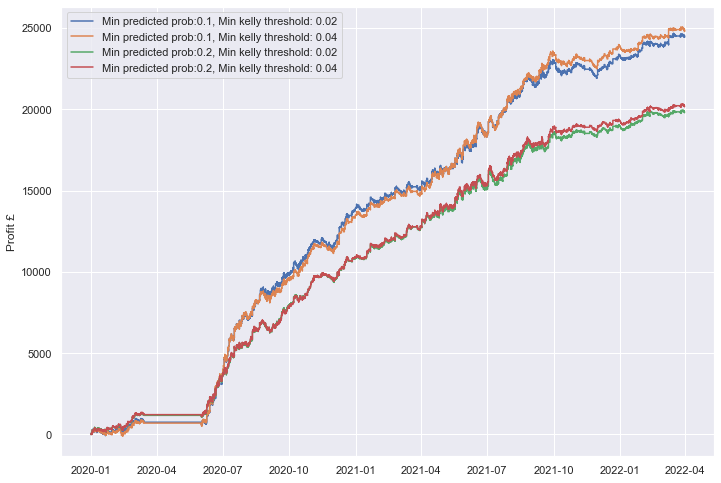

In [20]:
outs = []
params = []
for i in [0.1,0.2]:
    for j in [0.02,0.04]:
        params.append([i,j])
        outs.append(evaluate(test,prob_min=i, kelly_min = j))


pd.DataFrame([d[0] for d in outs])